In [1]:
import pandas as pd
import graspologic as gp
import seaborn as sns
import hyppo
import matplotlib.pyplot as plt
import numpy as np
import plotnine as p9

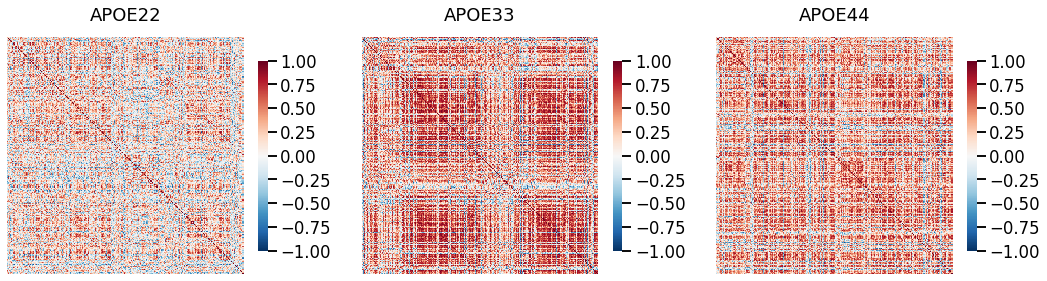

In [2]:
## Read the data

key = pd.read_csv('../data/processed/key.csv')
data = pd.read_csv('../data/processed/mouses-volumes.csv')

data.set_index(key.DWI, inplace=True)

genotypes = ['APOE22', 'APOE33', 'APOE44']


gen_animals = {genotype: None for genotype in genotypes}

for genotype in genotypes:
    gen_animals[genotype] = key.loc[key['Genotype'] == genotype]['DWI'].tolist()

vol_dat = {genotype: [] for genotype in genotypes}
    
for genotype in genotypes:
    vol_dat[genotype] = data.loc[gen_animals[genotype]].to_numpy()[:,1:]
    
## Compute correlations
cor_dat = {genotype: gp.utils.symmetrize(np.corrcoef(dat, rowvar=False)) for (genotype, dat) in vol_dat.items()}


## Plot to make sure nothing is wrong
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

for (i, genotype) in enumerate(cor_dat.keys()):
    gp.plot.heatmap(cor_dat[genotype], title=genotype, ax=ax[i], vmin=-1, vmax=1)

## Testing whether group volumes are significantly different

We compute 3-sample distance correlation to see if there is any differences in the 3 groups. Specifically, we test whether the distribution of brain volumes from at least two genotypes are different.

In [3]:
ksample = hyppo.ksample.KSample("dcorr")

stat, pval = ksample.test(*[dat for (genotype, dat) in vol_dat.items()])

print(pval)

0.006007509501547491


We see significant difference among the three genotypes

### Testing for most significantly different regions

Since we detect difference in at least two of the genotypes using the whole brain volumes, we repeat the procedure on each of the regions.

In [4]:
region_pvals = {reg: None for reg in data.columns[1:]}

for i, reg in enumerate(data.columns[1:]):
    region_vols = [dat[:, i] for (genotype, dat) in vol_dat.items()]
    stat, pval = ksample.test(*region_vols)

    region_pvals[reg] = pval

In [5]:
sorted_pvals = dict(sorted(region_pvals.items(), key=lambda item: item[1]))

In [6]:
pd.DataFrame(list(sorted_pvals.items())[:10], columns = ['Region', 'P-value'])

,Region,P-value
0,ml.1,0.000590
1,DTT,0.000763
2,PnC,0.001241
3,Cb_1_10.1,0.001744
4,PnRt,0.002679
5,Vll.1,0.003626
6,ml,0.004092
7,DTT.1,0.004172
8,SC.1,0.004264
9,ParB,0.005457


## Testing for differences in the brain volume covariance

Using similar procedure as above, we test whether the covariances are different among the genotypes. Prior to the 3-sample test, we use Omnibus embedding on the covariance matrices to obtain latent positions, which we then test for difference in distributions.

In [7]:
omni = gp.embed.OmnibusEmbed()

omni.fit([dat for (_, dat) in cor_dat.items()])

Xhats = omni.latent_left_
print(Xhats.shape)

(3, 332, 4)


In [8]:
ksample = hyppo.ksample.KSample("dcorr")

_, pval = ksample.test(*Xhats)

print(pval)

8.254124554923335e-26


We again see a significant difference in distributions

## Testing for differences in pairwise covariances

We then test for whether the distribution of each pair of genotypes are different.

In [9]:
genotypes = ['APOE22', 'APOE33', 'APOE44']

ksample = hyppo.ksample.KSample("dcorr")


res = []

for i, g in enumerate(genotypes):
    for j, h in enumerate(genotypes):
        if g == h:
            res.append([g, h, 1])
        else:
            _, pval = ksample.test(Xhats[i], Xhats[j])
            res.append([g, h, pval])

In [10]:
pairwise_df = pd.DataFrame(res, columns=["Genotype 1", "Genotype 2", "pvalue"])

In [11]:
pairwise_df["Genotype 1"] = pairwise_df["Genotype 1"].astype('category')
pairwise_df["Genotype 2"] = pairwise_df["Genotype 2"].astype('category')
pairwise_df["log(pvalue)"] = np.log(pairwise_df["pvalue"])

In [12]:
pairwise_df

,Genotype 1,Genotype 2,pvalue,log(pvalue)
0,APOE22,APOE22,1.000000e+00,0.000000
1,APOE22,APOE33,9.932969e-21,-46.058427
2,APOE22,APOE44,1.014474e-17,-39.129576
3,APOE33,APOE22,9.932969e-21,-46.058427
4,APOE33,APOE33,1.000000e+00,0.000000
5,APOE33,APOE44,3.573940e-16,-35.567693
6,APOE44,APOE22,1.014474e-17,-39.129576
7,APOE44,APOE33,3.573940e-16,-35.567693
8,APOE44,APOE44,1.000000e+00,0.000000


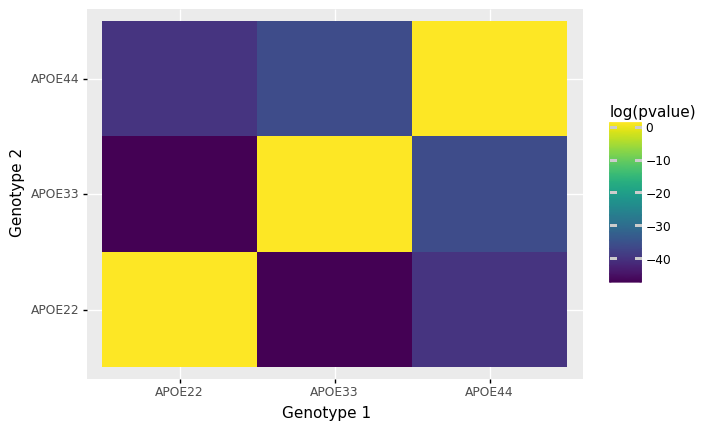

<ggplot: (8766045953917)>

In [13]:
plot = (p9.ggplot(p9.aes(x="Genotype 1", y="Genotype 2", fill="log(pvalue)")) +
  p9.geom_tile(pairwise_df))

plot